<a href="https://colab.research.google.com/github/Toa-0128/Data-Analysis-Final-Project-/blob/main/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import kagglehub
import pandas as pd
import numpy as np
import os

# 1. Download Dataset
# Data will be cached locally on the first run
path = kagglehub.dataset_download("cdc/national-health-and-nutrition-examination-survey")

print(f"Dataset downloaded to: {path}")

# 2. Load necessary CSV files
# Read each file from the path downloaded by kagglehub
def load_nhanes_csv(filename):
    full_path = os.path.join(path, filename)
    return pd.read_csv(full_path)

df_demo = load_nhanes_csv('demographic.csv')      # Age, household size, etc.
df_quest = load_nhanes_csv('questionnaire.csv')  # PHQ-9 (mental health), smoking, etc.
df_exam = load_nhanes_csv('examination.csv')      # BMI, etc.
df_labs = load_nhanes_csv('labs.csv')            # Blood sugar, cholesterol, etc.

# 3. Merge data by SEQN (common ID)
# Use 'inner' join to extract only participants included in all data
df = df_demo.merge(df_quest, on='SEQN') \
            .merge(df_exam, on='SEQN') \
            .merge(df_labs, on='SEQN')

# 4. Extract target for analysis (elderly aged 65 and over)
df_elderly = df[df['RIDAGEYR'] >= 65].copy()

# ---------------------------------------------------------
# 5. Preprocessing for mental health analysis
# ---------------------------------------------------------

# List PHQ-9 questionnaire items (DPQ010 to DPQ090)
phq9_cols = [f'DPQ{str(i).zfill(3)}' for i in range(10, 100, 10)]

# Replace missing values (7: refused, 9: unknown) with NaN, and calculate total score
for col in phq9_cols:
    df_elderly[col] = df_elderly[col].replace({7: np.nan, 9: np.nan})

# Calculate total if at least one item is answered (PHQ_Total)
df_elderly['PHQ_Total'] = df_elderly[phq9_cols].sum(axis=1, min_count=1)

# Definition of social isolation: if household size (DMDHHSIZ) is 1 person
df_elderly['Is_Isolated'] = (df_elderly['DMDHHSIZ'] == 1).astype(int)

print(f"Number of elderly subjects for analysis: {len(df_elderly)} individuals")
print(df_elderly[['PHQ_Total', 'DMDHHSIZ', 'Is_Isolated']].head())

Using Colab cache for faster access to the 'national-health-and-nutrition-examination-survey' dataset.
Dataset downloaded to: /kaggle/input/national-health-and-nutrition-examination-survey
Number of elderly subjects for analysis: 1265 individuals
    PHQ_Total  DMDHHSIZ  Is_Isolated
0         1.0         3            0
2         0.0         2            0
4         9.0         2            0
9         3.0         1            1
12        6.0         2            0


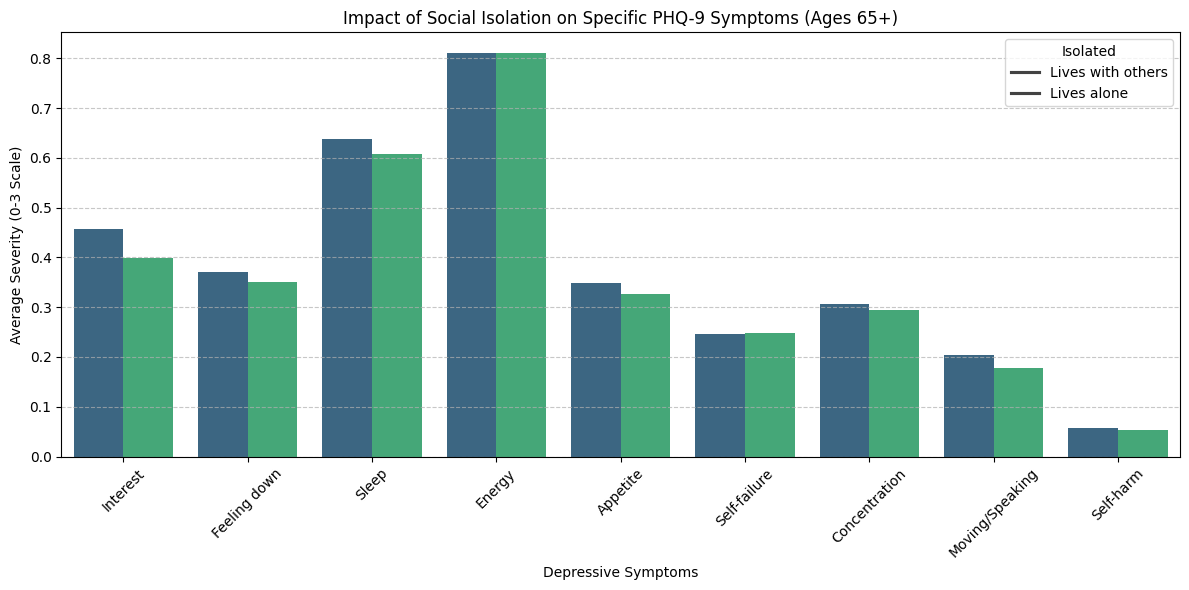

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Japanese labels for questionnaire items (for graph display)
phq9_labels = [
    "Interest", "Feeling down", "Sleep", "Energy",
    "Appetite", "Self-failure", "Concentration", "Moving/Speaking", "Self-harm"
]
# Corresponding column names: DPQ010, DPQ020, ..., DPQ090

# 2. Data aggregation: Calculate the average of each item by social isolation status (Is_Isolated)
symptom_means = df_elderly.groupby('Is_Isolated')[phq9_cols].mean().reset_index()

# 3. Transform data shape for graphing (Melt)
plot_data = symptom_means.melt(id_vars='Is_Isolated', var_name='Symptom', value_name='Average Score')
plot_data['Symptom_Label'] = plot_data['Symptom'].map(dict(zip(phq9_cols, phq9_labels)))

# 4. Visualization
plt.figure(figsize=(12, 6))
sns.barplot(x='Symptom_Label', y='Average Score', hue='Is_Isolated', data=plot_data, palette='viridis')

plt.title('Impact of Social Isolation on Specific PHQ-9 Symptoms (Ages 65+)')
plt.ylabel('Average Severity (0-3 Scale)')
plt.xlabel('Depressive Symptoms')
plt.legend(title='Isolated', labels=['Lives with others', 'Lives alone'])
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

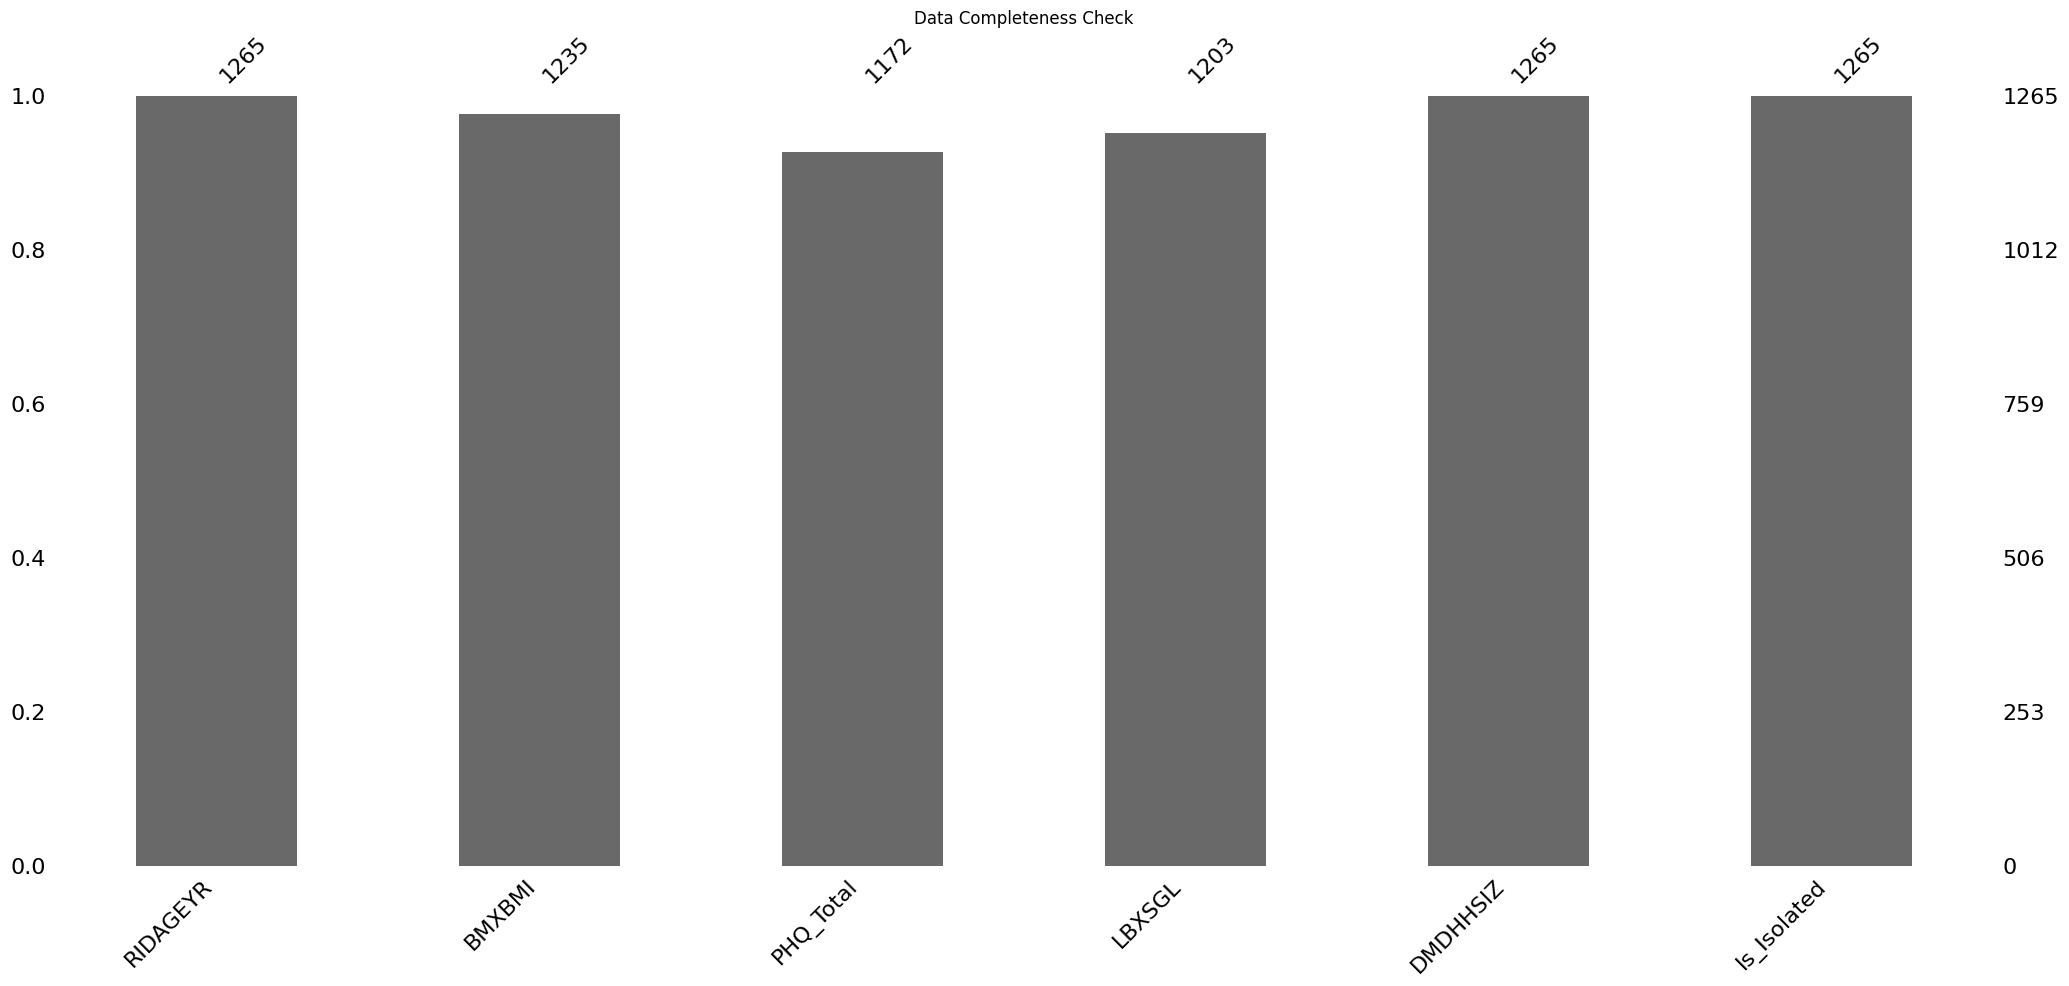

In [20]:
import missingno as msno

# Pick up key variables for analysis
cols_to_check = ['RIDAGEYR', 'BMXBMI', 'PHQ_Total', 'LBXSGL', 'DMDHHSIZ', 'Is_Isolated']

# Display bar chart of missing values
msno.bar(df_elderly[cols_to_check])
plt.title('Data Completeness Check')
plt.show()

### Descriptive Statistics for Continuous Variables ###
          RIDAGEYR       BMXBMI    PHQ_Total       LBXSGL
count  1265.000000  1235.000000  1172.000000  1203.000000
mean     73.210277    28.616194     3.383959   114.684123
std       5.341951     5.814167     4.292390    44.641947
min      65.000000    14.200000     0.000000    49.000000
25%      68.000000    24.600000     0.000000    92.000000
50%      73.000000    27.800000     2.000000   101.000000
75%      80.000000    31.650000     5.000000   120.000000
max      80.000000    62.200000    24.000000   554.000000


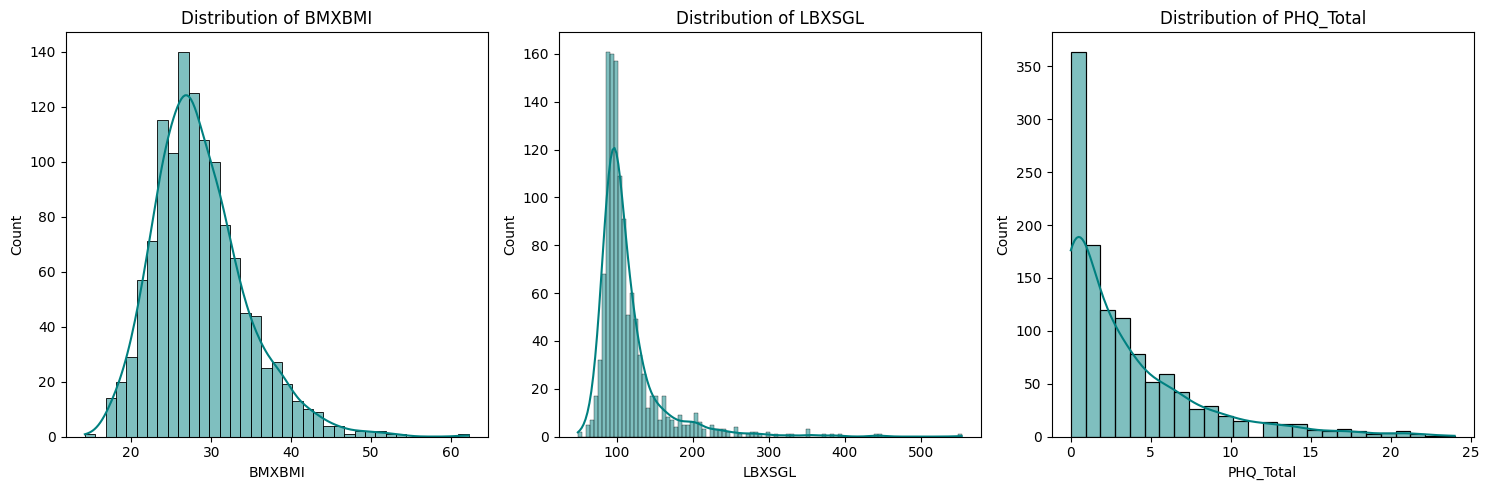

In [21]:
# Descriptive statistics for key variables (mean, median, standard deviation, etc.)
print("### Descriptive Statistics for Continuous Variables ###")
print(df_elderly[['RIDAGEYR', 'BMXBMI', 'PHQ_Total', 'LBXSGL']].describe())

# Histograms and density curves
plt.figure(figsize=(15, 5))
for i, col in enumerate(['BMXBMI', 'LBXSGL', 'PHQ_Total']):
    plt.subplot(1, 3, i+1)
    sns.histplot(df_elderly[col], kde=True, color='teal')
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

/tmp/ipython-input-2667128722.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Is_Isolated', y='BMXBMI', data=df_elderly, palette='Set2')


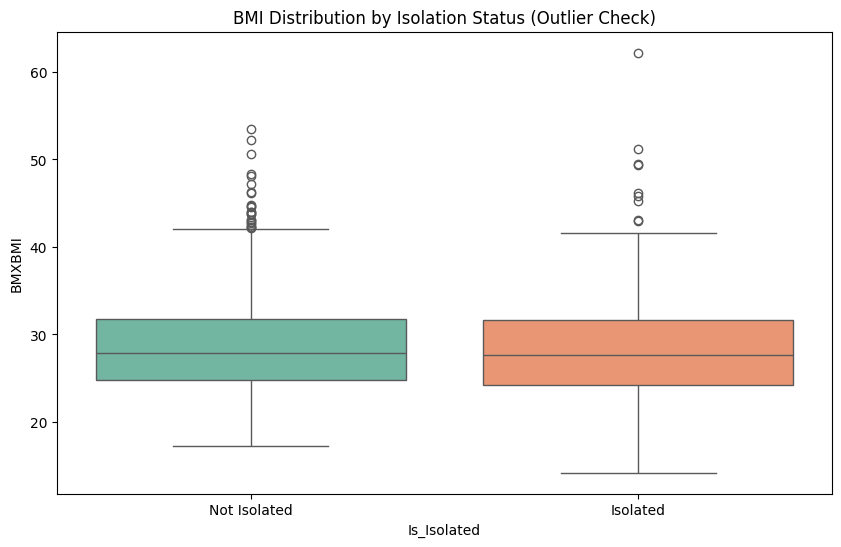

In [22]:
plt.figure(figsize=(10, 6))
# BMI distribution by isolation status (Is_Isolated)
sns.boxplot(x='Is_Isolated', y='BMXBMI', data=df_elderly, palette='Set2')
plt.title('BMI Distribution by Isolation Status (Outlier Check)')
plt.xticks([0, 1], ['Not Isolated', 'Isolated'])
plt.show()

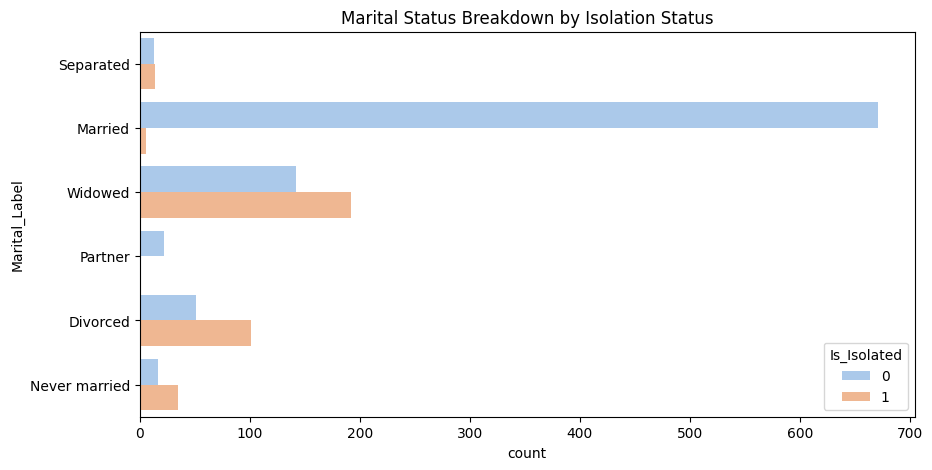

In [23]:
# Check the composition of marital status (DMDMARTL)
# 1:Married, 2:Widowed, 3:Divorced, 4:Separated, 5:Never married, 6:Living with partner
marital_labels = {1:'Married', 2:'Widowed', 3:'Divorced', 4:'Separated', 5:'Never married', 6:'Partner'}
df_elderly['Marital_Label'] = df_elderly['DMDMARTL'].map(marital_labels)

plt.figure(figsize=(10, 5))
sns.countplot(y='Marital_Label', hue='Is_Isolated', data=df_elderly, palette='pastel')
plt.title('Marital Status Breakdown by Isolation Status')
plt.show()